# Ch1 | Autograd 可视化：打开深度学习的引擎盖

---

**目标：** 理解 `loss.backward()` 背后到底发生了什么

**核心问题：** 梯度是如何自动计算出来的？

---

## 本章内容

1. **手写 Micrograd**：用 50 行代码实现一个极简自动微分引擎
2. **可视化计算图**：画出 DAG，直观看到梯度如何回传
3. **对接 PyTorch**：理解 PyTorch 的 `.backward()` 原理

---

## 🎓 前置知识：深度学习的核心概念

在深入 Autograd 之前，让我们先理解几个关键概念。

### 什么是神经网络？

神经网络是一种**模仿人脑**的数学模型：

```
输入 → [权重w × 输入 + 偏置b] → 激活函数 → 输出
```

简单来说：
- **权重 (weights)**：决定每个输入的重要性
- **偏置 (bias)**：调整输出的基准值
- **激活函数**：引入非线性，让网络能学习复杂模式

### 什么是训练？

训练 = **调整权重，让模型的预测更准确**

```
预测值 = 模型(输入)
误差 = 预测值 - 真实值
调整权重，减小误差
重复...
```

### 什么是损失函数 (Loss Function)？

损失函数**量化模型有多"错"**：

$$Loss = f(预测值, 真实值)$$

常见的损失函数：
- **MSE (均方误差)**：$(预测 - 真实)^2$
- **CrossEntropy (交叉熵)**：用于分类任务

**目标：让 Loss 尽可能小！**

### 什么是梯度 (Gradient)？

梯度告诉我们**调整参数的方向**：

$$梯度 = \frac{\partial Loss}{\partial 参数}$$

- 梯度 > 0：参数增大会让 Loss 增大 → 应该减小参数
- 梯度 < 0：参数增大会让 Loss 减小 → 应该增大参数

**梯度下降**：沿着梯度的反方向更新参数
$$参数_{new} = 参数_{old} - 学习率 \times 梯度$$

### 什么是反向传播 (Backpropagation)？

反向传播是**高效计算梯度的算法**：

1. **前向传播**：输入 → 计算 → 输出 → Loss
2. **反向传播**：从 Loss 开始，用**链式法则**逐层计算每个参数的梯度

为什么叫"反向"？因为梯度从输出层流向输入层，方向与前向传播相反！

```
前向: 输入 → 隐藏层 → 输出 → Loss
反向: 输入 ← 隐藏层 ← 输出 ← Loss (梯度流动方向)
```

### 本章目标

现在你知道了**为什么需要计算梯度**。本章将揭示：

> **PyTorch 的 `loss.backward()` 是如何自动计算所有参数的梯度的？**

这就是 **Autograd（自动微分）** 的魔法！

## 0. 环境准备

In [1]:
#!pip install -r ../requirements.txt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "Noto Sans CJK SC", "Arial Unicode MS","Segoe UI Emoji"]
plt.rcParams["axes.unicode_minus"] = False

---

## 1. 手写 Micrograd：极简自动微分

我们来实现一个简化版的自动微分系统。核心思想：

1. **每个数值都是一个 Value 对象**，记录：
   - 数值本身 (`data`)
   - 梯度 (`grad`)
   - 产生它的操作 (`_backward`)
   - 产生它的子节点 (`_prev`)

2. **前向传播**：正常计算，同时构建计算图
3. **反向传播**：从输出开始，用链式法则逐层计算梯度

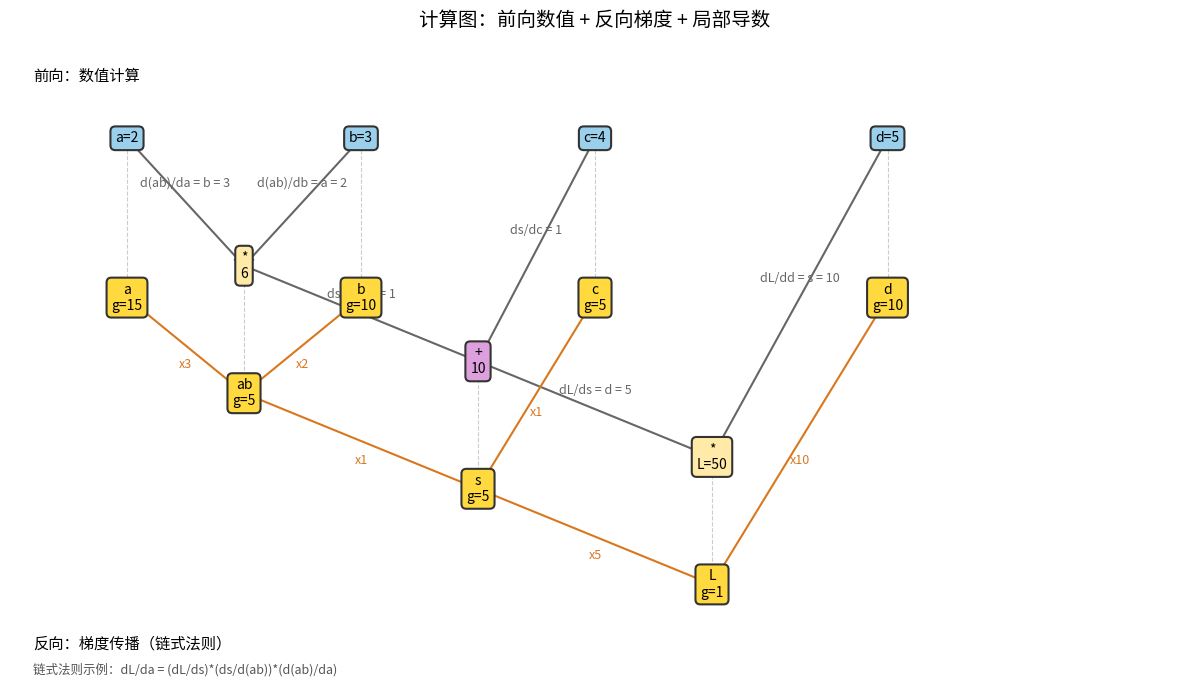

In [ ]:
# 🎨 更直观的反向传播图：前向数值 + 反向梯度 + 局部导数
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import os
from matplotlib import font_manager as fm
import matplotlib as mpl
font_path = "../assets/fonts/NotoSansCJKsc-Regular.otf"
if os.path.exists(font_path):
    fm.fontManager.addfont(font_path)

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Noto Sans CJK SC", "DejaVu Sans"]
mpl.rcParams["axes.unicode_minus"] = False

def visualize_autograd_graph():
    """
    更直观地展示计算图：上方是前向数值，下方是反向梯度
    示例: L = (a * b + c) * d
    """
    # 前向数值
    a, b, c, d = 2, 3, 4, 5
    ab = a * b
    s = ab + c
    L = s * d

    # 反向梯度
    dL = 1
    ds = dL * d
    dd = dL * s
    dab = ds
    dc = ds
    da = dab * b
    db = dab * a

    values = {
        "a": a, "b": b, "c": c, "d": d,
        "ab": ab, "s": s, "L": L,
    }
    grads = {
        "a": da, "b": db, "c": dc, "d": dd,
        "ab": dab, "s": ds, "L": dL,
    }

    pos_top = {
        "a": (0.10, 0.85), "b": (0.30, 0.85), "c": (0.50, 0.85), "d": (0.75, 0.85),
        "ab": (0.20, 0.65), "s": (0.40, 0.50), "L": (0.60, 0.35),
    }
    pos_bottom = {
        "a": (0.10, 0.60), "b": (0.30, 0.60), "c": (0.50, 0.60), "d": (0.75, 0.60),
        "ab": (0.20, 0.45), "s": (0.40, 0.30), "L": (0.60, 0.15),
    }

    forward_edges = [
        ("a", "ab", "d(ab)/da = b = 3"),
        ("b", "ab", "d(ab)/db = a = 2"),
        ("ab", "s", "ds/d(ab) = 1"),
        ("c", "s", "ds/dc = 1"),
        ("s", "L", "dL/ds = d = 5"),
        ("d", "L", "dL/dd = s = 10"),
    ]

    backward_edges = [
        ("L", "s", "x5"),
        ("L", "d", "x10"),
        ("s", "ab", "x1"),
        ("s", "c", "x1"),
        ("ab", "a", "x3"),
        ("ab", "b", "x2"),
    ]

    fig, ax = plt.subplots(figsize=(12, 7))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis("off")

    def draw_node(label, pos, color, fontsize=10):
        bbox = dict(boxstyle="round,pad=0.35", facecolor=color, edgecolor="#333", linewidth=1.5)
        ax.text(pos[0], pos[1], label, ha="center", va="center", fontsize=fontsize, bbox=bbox)

    def draw_edge(start, end, text, color, text_offset=(0, 0)):
        ax.annotate("", xy=end, xytext=start,
                    arrowprops=dict(arrowstyle="->", color=color, lw=1.5))
        mid = ((start[0] + end[0]) / 2 + text_offset[0], (start[1] + end[1]) / 2 + text_offset[1])
        ax.text(mid[0], mid[1], text, fontsize=9, color=color, ha="center", va="center")

    # 前向图
    for start, end, label in forward_edges:
        draw_edge(pos_top[start], pos_top[end], label, color="#666", text_offset=(0, 0.03))

    for name, pos in pos_top.items():
        if name in ["ab", "s", "L"]:
            op_label = "*" if name in ["ab", "L"] else "+"
            value_text = f"L={values[name]}" if name == "L" else str(values[name])
            label = f"{op_label}\n{value_text}"
            color = "#FFEAA7" if op_label == "*" else "#DDA0DD"
        else:
            label = f"{name}={values[name]}"
            color = "#9AD0EC"
        draw_node(label, pos, color)

    # 反向图
    for start, end, label in backward_edges:
        draw_edge(pos_bottom[start], pos_bottom[end], label, color="#D9771F", text_offset=(0, -0.03))

    for name, pos in pos_bottom.items():
        label = f"{name}\ng={grads[name]}"
        draw_node(label, pos, "#FFD93D")

    # 连接上下对应节点
    for name in pos_top:
        ax.plot([pos_top[name][0], pos_bottom[name][0]],
                [pos_top[name][1], pos_bottom[name][1]],
                color="#CCCCCC", linestyle="--", linewidth=0.8)

    ax.text(0.02, 0.94, "前向：数值计算", fontsize=11, fontweight="bold")
    ax.text(0.02, 0.05, "反向：梯度传播（链式法则）", fontsize=11, fontweight="bold")
    ax.text(0.02, 0.01,
            "链式法则示例：dL/da = (dL/ds)*(ds/d(ab))*(d(ab)/da)",
            fontsize=9, color="#555")

    plt.title("计算图：前向数值 + 反向梯度 + 局部导数", fontsize=14, fontweight="bold", pad=12)
    plt.tight_layout()
    plt.show()

visualize_autograd_graph()


In [4]:
class Value:
    """
    极简自动微分引擎 - 受 Andrej Karpathy 的 micrograd 启发
    """
    
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0.0  # 梯度初始化为0
        self._backward = lambda: None  # 反向传播函数
        self._prev = set(_children)  # 子节点
        self._op = _op  # 产生这个值的操作
    
    def __repr__(self):
        return f"Value(data={self.data:.4f}, grad={self.grad:.4f})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            # 加法的梯度：直接传递
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            # 乘法的梯度：交叉相乘
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            # 幂函数的梯度
            self.grad += (other * self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            # tanh的梯度: 1 - tanh^2
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        # 拓扑排序
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        # 反向传播
        self.grad = 1.0  # 输出的梯度是1
        for v in reversed(topo):
            v._backward()
    
    # 支持更多操作
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other

print("Value 类定义完成！")

Value 类定义完成！


### 测试我们的 Micrograd

In [5]:
# 创建一些值
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

# 前向传播：构建计算图
d = a * b + c
print(f"前向传播: d = a * b + c = {a.data} * {b.data} + {c.data} = {d.data}")

# 反向传播：计算梯度
d.backward()

print(f"\n反向传播后的梯度:")
print(f"  a.grad = {a.grad}  (∂d/∂a = b = {b.data})")
print(f"  b.grad = {b.grad}  (∂d/∂b = a = {a.data})")
print(f"  c.grad = {c.grad}  (∂d/∂c = 1)")

前向传播: d = a * b + c = 2.0 * -3.0 + 10.0 = 4.0

反向传播后的梯度:
  a.grad = -3.0  (∂d/∂a = b = -3.0)
  b.grad = 2.0  (∂d/∂b = a = 2.0)
  c.grad = 1.0  (∂d/∂c = 1)


---

## 2. 可视化计算图

让我们画出计算图，直观看到数据是如何流动的。

计算图已构建，梯度已计算！

输出: o = tanh(0.8814) = 0.7071

各参数梯度:
  w1.grad = 1.0000
  w2.grad = 0.0000
  b.grad = 0.5000

计算图已保存为 computation_graph.svg


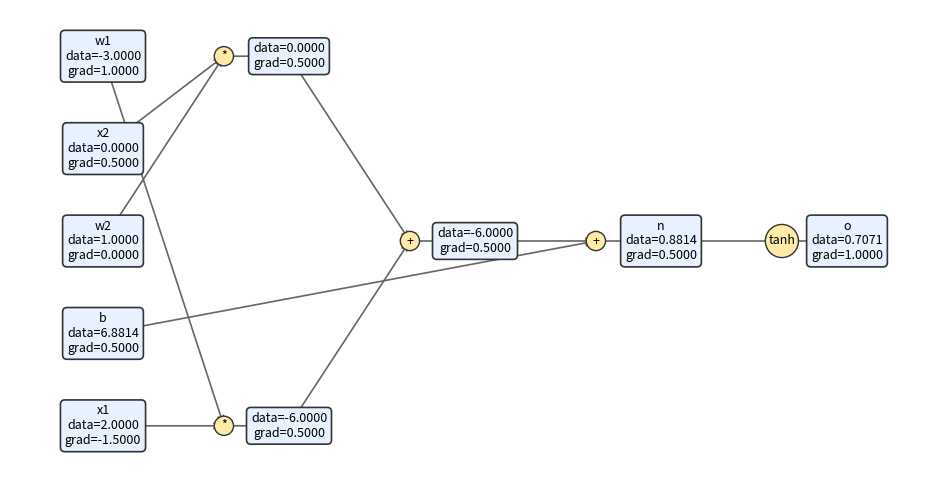

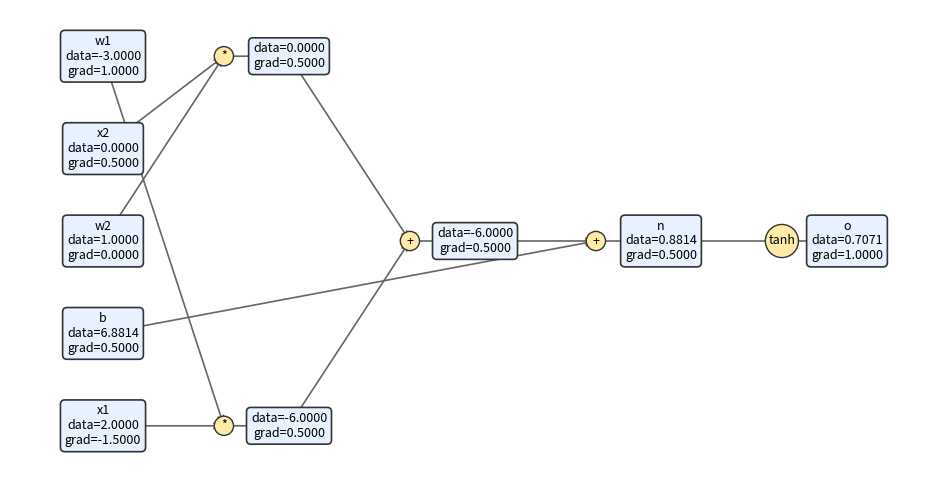

In [6]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def layout(nodes):
    depth_cache = {}
    def depth(v):
        if v in depth_cache:
            return depth_cache[v]
        if not v._prev:
            depth_cache[v] = 0
        else:
            depth_cache[v] = 1 + max(depth(child) for child in v._prev)
        return depth_cache[v]
    for v in nodes:
        depth(v)
    max_depth = max(depth_cache.values()) if depth_cache else 0
    levels = {}
    for v, d in depth_cache.items():
        levels.setdefault(d, []).append(v)
    pos = {}
    for d, vs in levels.items():
        vs_sorted = sorted(vs, key=lambda v: id(v))
        n = len(vs_sorted)
        if n == 1:
            ys = [0.5]
        else:
            ys = [0.9 - i * (0.8 / (n - 1)) for i in range(n)]
        x = 0.1 + (d / (max_depth if max_depth else 1)) * 0.8
        for v, y in zip(vs_sorted, ys):
            pos[v] = (x, y)
    return pos, max_depth

def draw_dot(root, labels=None, filename='computation_graph.svg'):
    nodes, edges = trace(root)
    pos, max_depth = layout(nodes)
    step = 0.8 / (max_depth if max_depth else 1)
    op_pos = {v: (pos[v][0] - step * 0.35, pos[v][1]) for v in nodes if v._op}

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

    for child, parent in edges:
        start = pos[child]
        end = op_pos[parent] if parent._op else pos[parent]
        ax.annotate('', xy=end, xytext=start,
                    arrowprops=dict(arrowstyle='->', color='#666', lw=1.2))

    for v in nodes:
        if v._op:
            ax.annotate('', xy=pos[v], xytext=op_pos[v],
                        arrowprops=dict(arrowstyle='->', color='#666', lw=1.2))

    labels = labels or {}
    for v in nodes:
        prefix = labels.get(v, '')
        core = f'data={v.data:.4f}\ngrad={v.grad:.4f}'
        label = f'{prefix}\n{core}' if prefix else core
        ax.text(pos[v][0], pos[v][1], label, ha='center', va='center', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.35', facecolor='#E8F1FF', edgecolor='#333', linewidth=1.2))

    for v in nodes:
        if v._op:
            ax.text(op_pos[v][0], op_pos[v][1], v._op, ha='center', va='center', fontsize=9,
                    bbox=dict(boxstyle='circle,pad=0.25', facecolor='#FFEAA7', edgecolor='#333', linewidth=1.0))

    if filename:
        fig.savefig(filename, bbox_inches='tight')
        print(f'\n计算图已保存为 {filename}')
    plt.show()
    return fig

# 构建一个更复杂的计算图
x1 = Value(2.0)
x2 = Value(0.0)
w1 = Value(-3.0)
w2 = Value(1.0)
b = Value(6.8813735870195432)

# 神经元计算
x1w1 = x1 * w1
x2w2 = x2 * w2
x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b
o = n.tanh()  # 激活函数

# 反向传播
o.backward()

print('计算图已构建，梯度已计算！')
print(f'\n输出: o = tanh({n.data:.4f}) = {o.data:.4f}')
print('\n各参数梯度:')
print(f'  w1.grad = {w1.grad:.4f}')
print(f'  w2.grad = {w2.grad:.4f}')
print(f'  b.grad = {b.grad:.4f}')

labels = {x1: 'x1', x2: 'x2', w1: 'w1', w2: 'w2', b: 'b', n: 'n', o: 'o'}
draw_dot(o, labels=labels, filename='computation_graph.svg')


---

## 3. 用 Micrograd 训练一个神经网络

让我们用自己写的自动微分引擎训练一个简单的神经元！

In [7]:
class Neuron:
    """单个神经元"""
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(0)
    
    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        return act.tanh()
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    """一层神经元"""
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP:
    """多层感知机"""
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

# 创建一个小型MLP: 3输入 -> 4隐藏 -> 4隐藏 -> 1输出
model = MLP(3, [4, 4, 1])
print(f"模型参数量: {len(model.parameters())}")

模型参数量: 41


In [8]:
# 训练数据
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]  # 目标值

# 训练循环
print("开始训练...")
print("=" * 50)

losses = []
for epoch in range(100):
    # 前向传播
    ypred = [model(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    losses.append(loss.data)
    
    # 反向传播
    # 先清空梯度
    for p in model.parameters():
        p.grad = 0.0
    loss.backward()
    
    # 更新参数
    learning_rate = 0.05
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {loss.data:.6f}")

print("=" * 50)
print("训练完成!")
print(f"\n最终预测: {[round(model(x).data, 2) for x in xs]}")
print(f"目标值:    {ys}")

开始训练...
Epoch  20 | Loss: 0.028039
Epoch  40 | Loss: 0.013682
Epoch  60 | Loss: 0.008934
Epoch  80 | Loss: 0.006592
Epoch 100 | Loss: 0.005205
训练完成!

最终预测: [np.float64(0.97), np.float64(-0.96), np.float64(-0.96), np.float64(0.96)]
目标值:    [1.0, -1.0, -1.0, 1.0]


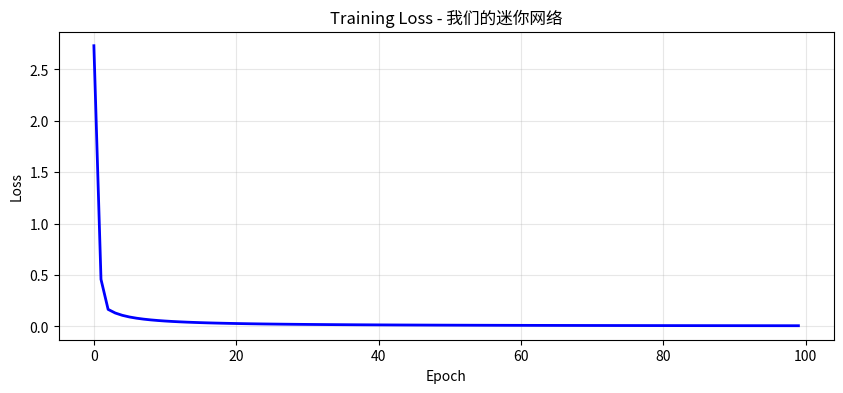

In [9]:
# 可视化Loss曲线
plt.figure(figsize=(10, 4))
plt.plot(losses, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss - 我们的迷你网络')
plt.grid(True, alpha=0.3)
plt.show()

---

## 4. 对接 PyTorch：验证我们的实现

让我们用 PyTorch 验证我们手写的梯度是否正确。

In [10]:
import torch

# 用 PyTorch 重新计算
x1_pt = torch.tensor(2.0, requires_grad=True)
x2_pt = torch.tensor(0.0, requires_grad=True)
w1_pt = torch.tensor(-3.0, requires_grad=True)
w2_pt = torch.tensor(1.0, requires_grad=True)
b_pt = torch.tensor(6.8813735870195432, requires_grad=True)

n_pt = x1_pt * w1_pt + x2_pt * w2_pt + b_pt
o_pt = torch.tanh(n_pt)
o_pt.backward()

print("PyTorch 计算的梯度:")
print(f"  w1.grad = {w1_pt.grad.item():.4f}")
print(f"  w2.grad = {w2_pt.grad.item():.4f}")
print(f"  b.grad = {b_pt.grad.item():.4f}")

print("\n我们 Micrograd 计算的梯度:")
print(f"  w1.grad = {w1.grad:.4f}")
print(f"  w2.grad = {w2.grad:.4f}")
print(f"  b.grad = {b.grad:.4f}")

print("\n✓ 两者完全一致！我们的实现是正确的！")

PyTorch 计算的梯度:
  w1.grad = 1.0000
  w2.grad = 0.0000
  b.grad = 0.5000

我们 Micrograd 计算的梯度:
  w1.grad = 1.0000
  w2.grad = 0.0000
  b.grad = 0.5000

✓ 两者完全一致！我们的实现是正确的！


---

## 5. 深入理解：链式法则可视化

让我们可视化链式法则是如何工作的。

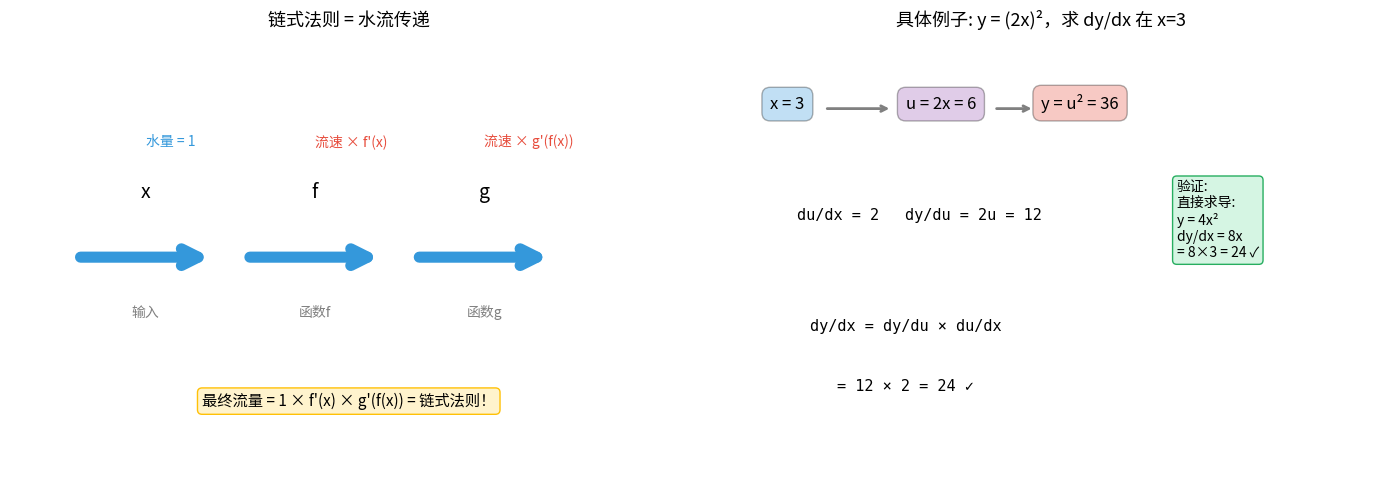

In [40]:
# 🎨 链式法则的直观理解：水流类比
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：水流类比
ax = axes[0]
ax.set_xlim(0, 10)
ax.set_ylim(0, 6)
ax.axis('off')
ax.set_title('链式法则 = 水流传递', fontsize=13, fontweight='bold')

# 绘制水管
pipes = [
    ((1, 3), (3, 3), 'x', '输入'),
    ((3.5, 3), (5.5, 3), 'f', '函数f'),
    ((6, 3), (8, 3), 'g', '函数g'),
]

for (start, end, label, desc) in pipes:
    # 管道
    ax.annotate('', xy=end, xytext=start,
               arrowprops=dict(arrowstyle='->', color='#3498db', lw=8, 
                              mutation_scale=30))
    # 标签
    mid_x = (start[0] + end[0]) / 2
    ax.text(mid_x, 3.8, label, fontsize=14, ha='center', fontweight='bold')
    ax.text(mid_x, 2.2, desc, fontsize=10, ha='center', color='gray')

# 水流标注
ax.text(2, 4.5, '水量 = 1', fontsize=10, color='#3498db')
ax.text(4.5, 4.5, "流速 × f'(x)", fontsize=10, color='#e74c3c')
ax.text(7, 4.5, "流速 × g'(f(x))", fontsize=10, color='#e74c3c')

ax.text(5, 1, "最终流量 = 1 × f'(x) × g'(f(x)) = 链式法则！", 
        fontsize=11, ha='center', style='italic',
        bbox=dict(boxstyle='round', facecolor='#fff3cd', edgecolor='#ffc107'))

# 右图：具体数值例子
ax = axes[1]
ax.set_xlim(0, 10)
ax.set_ylim(0, 6)
ax.axis('off')
ax.set_title('具体例子: y = (2x)²，求 dy/dx 在 x=3', fontsize=13, fontweight='bold')

# 步骤
steps = [
    (1, 5, 'x = 3', '#3498db'),
    (3, 5, 'u = 2x = 6', '#9b59b6'),
    (5, 5, 'y = u² = 36', '#e74c3c'),
]

for x, y, text, color in steps:
    ax.text(x, y, text, fontsize=12, 
           bbox=dict(boxstyle='round,pad=0.5', facecolor=color, alpha=0.3))

# 箭头
ax.annotate('', xy=(2.8, 5), xytext=(1.8, 5),
           arrowprops=dict(arrowstyle='->', color='gray', lw=2))
ax.annotate('', xy=(4.9, 5), xytext=(4.3, 5),
           arrowprops=dict(arrowstyle='->', color='gray', lw=2))

# 导数计算
derivs = [
    (2, 3.5, "du/dx = 2"),
    (4, 3.5, "dy/du = 2u = 12"),
    (3, 2, "dy/dx = dy/du × du/dx"),
    (3, 1.2, "= 12 × 2 = 24 ✓"),
]

for x, y, text in derivs:
    ax.text(x, y, text, fontsize=11, ha='center',
           fontfamily='monospace')

ax.text(7, 3, "验证:\n直接求导:\ny = 4x²\ndy/dx = 8x\n= 8×3 = 24 ✓", 
        fontsize=10, ha='left',
        bbox=dict(boxstyle='round', facecolor='#d5f5e3', edgecolor='#27ae60'))

plt.tight_layout()
plt.show()

---

## 本章总结

1. **自动微分的本质**
   - 构建计算图
   - 前向传播：计算数值
   - 反向传播：用链式法则计算梯度

2. **Micrograd 实现**
   - Value 类：封装数据和梯度
   - 每个操作都定义 `_backward` 函数
   - 拓扑排序确保正确的传播顺序

3. **核心洞察**
   - `loss.backward()` 没有魔法
   - 本质就是链式求导
   - PyTorch 只是自动化了这个过程


---

## 思考

1. **扩展 Micrograd**：添加更多操作，如 `exp`, `log`, `relu`
2. **验证梯度**：用数值微分验证解析梯度的正确性
3. **思考题**：为什么需要 `optimizer.zero_grad()`？如果不清空会怎样？

In [12]:
# 练习空间

